In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score, classification_report, mean_squared_error
import warnings
warnings.filterwarnings('ignore')

plt.style.use('ggplot')
sns.set(style="whitegrid")

%matplotlib inline

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 50)
pd.set_option('display.width', 1000)


In [37]:
df = pd.read_csv('personalized_learning_dataset.csv')

print(f"Dataset shape: {df.shape}")
print(f"Number of students: {df['Student_ID'].nunique()}")
print(f"Number of courses: {df['Course_Name'].nunique()}")

print("\nFirst 5 rows of the dataset:")
display(df.head())

print("\nColumn information:")
df.info()

print("\nSummary statistics:")
display(df.describe())

# Check for missing values
print("\nMissing values in each column:")
display(df.isnull().sum())

Dataset shape: (10000, 15)
Number of students: 10000
Number of courses: 5

First 5 rows of the dataset:


,Student_ID,Age,Gender,Education_Level,Course_Name,Time_Spent_on_Videos,Quiz_Attempts,Quiz_Scores,Forum_Participation,Assignment_Completion_Rate,Engagement_Level,Final_Exam_Score,Learning_Style,Feedback_Score,Dropout_Likelihood
0,S00001,15,Female,High School,Machine Learning,171,4,67,2,89,Medium,51,Visual,1,No
1,S00002,49,Male,Undergraduate,Python Basics,156,4,64,0,94,Medium,92,Reading/Writing,5,No
2,S00003,20,Female,Undergraduate,Python Basics,217,2,55,2,67,Medium,45,Reading/Writing,1,No
3,S00004,37,Female,Undergraduate,Data Science,489,1,65,43,60,High,59,Visual,4,No
4,S00005,34,Female,Postgraduate,Python Basics,496,3,59,34,88,Medium,93,Visual,3,No



Column information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 15 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   Student_ID                  10000 non-null  object
 1   Age                         10000 non-null  int64 
 2   Gender                      10000 non-null  object
 3   Education_Level             10000 non-null  object
 4   Course_Name                 10000 non-null  object
 5   Time_Spent_on_Videos        10000 non-null  int64 
 6   Quiz_Attempts               10000 non-null  int64 
 7   Quiz_Scores                 10000 non-null  int64 
 8   Forum_Participation         10000 non-null  int64 
 9   Assignment_Completion_Rate  10000 non-null  int64 
 10  Engagement_Level            10000 non-null  object
 11  Final_Exam_Score            10000 non-null  int64 
 12  Learning_Style              10000 non-null  object
 13  Feedback_Score            

,Age,Time_Spent_on_Videos,Quiz_Attempts,Quiz_Scores,Forum_Participation,Assignment_Completion_Rate,Final_Exam_Score,Feedback_Score
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,32.137700,255.375400,2.500500,64.578600,24.616200,69.546800,64.697000,3.012600
std,10.062647,141.656392,1.122642,20.289125,14.330305,17.360782,20.096417,1.421423
min,15.000000,10.000000,1.000000,30.000000,0.000000,40.000000,30.000000,1.000000
25%,24.000000,131.000000,1.000000,47.000000,12.000000,54.000000,47.000000,2.000000
50%,32.000000,257.000000,3.000000,65.000000,25.000000,69.000000,65.000000,3.000000
75%,41.000000,378.000000,4.000000,82.000000,37.000000,85.000000,82.000000,4.000000
max,49.000000,499.000000,4.000000,99.000000,49.000000,99.000000,99.000000,5.000000



Missing values in each column:


Student_ID                    0
Age                           0
Gender                        0
Education_Level               0
Course_Name                   0
Time_Spent_on_Videos          0
Quiz_Attempts                 0
Quiz_Scores                   0
Forum_Participation           0
Assignment_Completion_Rate    0
Engagement_Level              0
Final_Exam_Score              0
Learning_Style                0
Feedback_Score                0
Dropout_Likelihood            0
dtype: int64

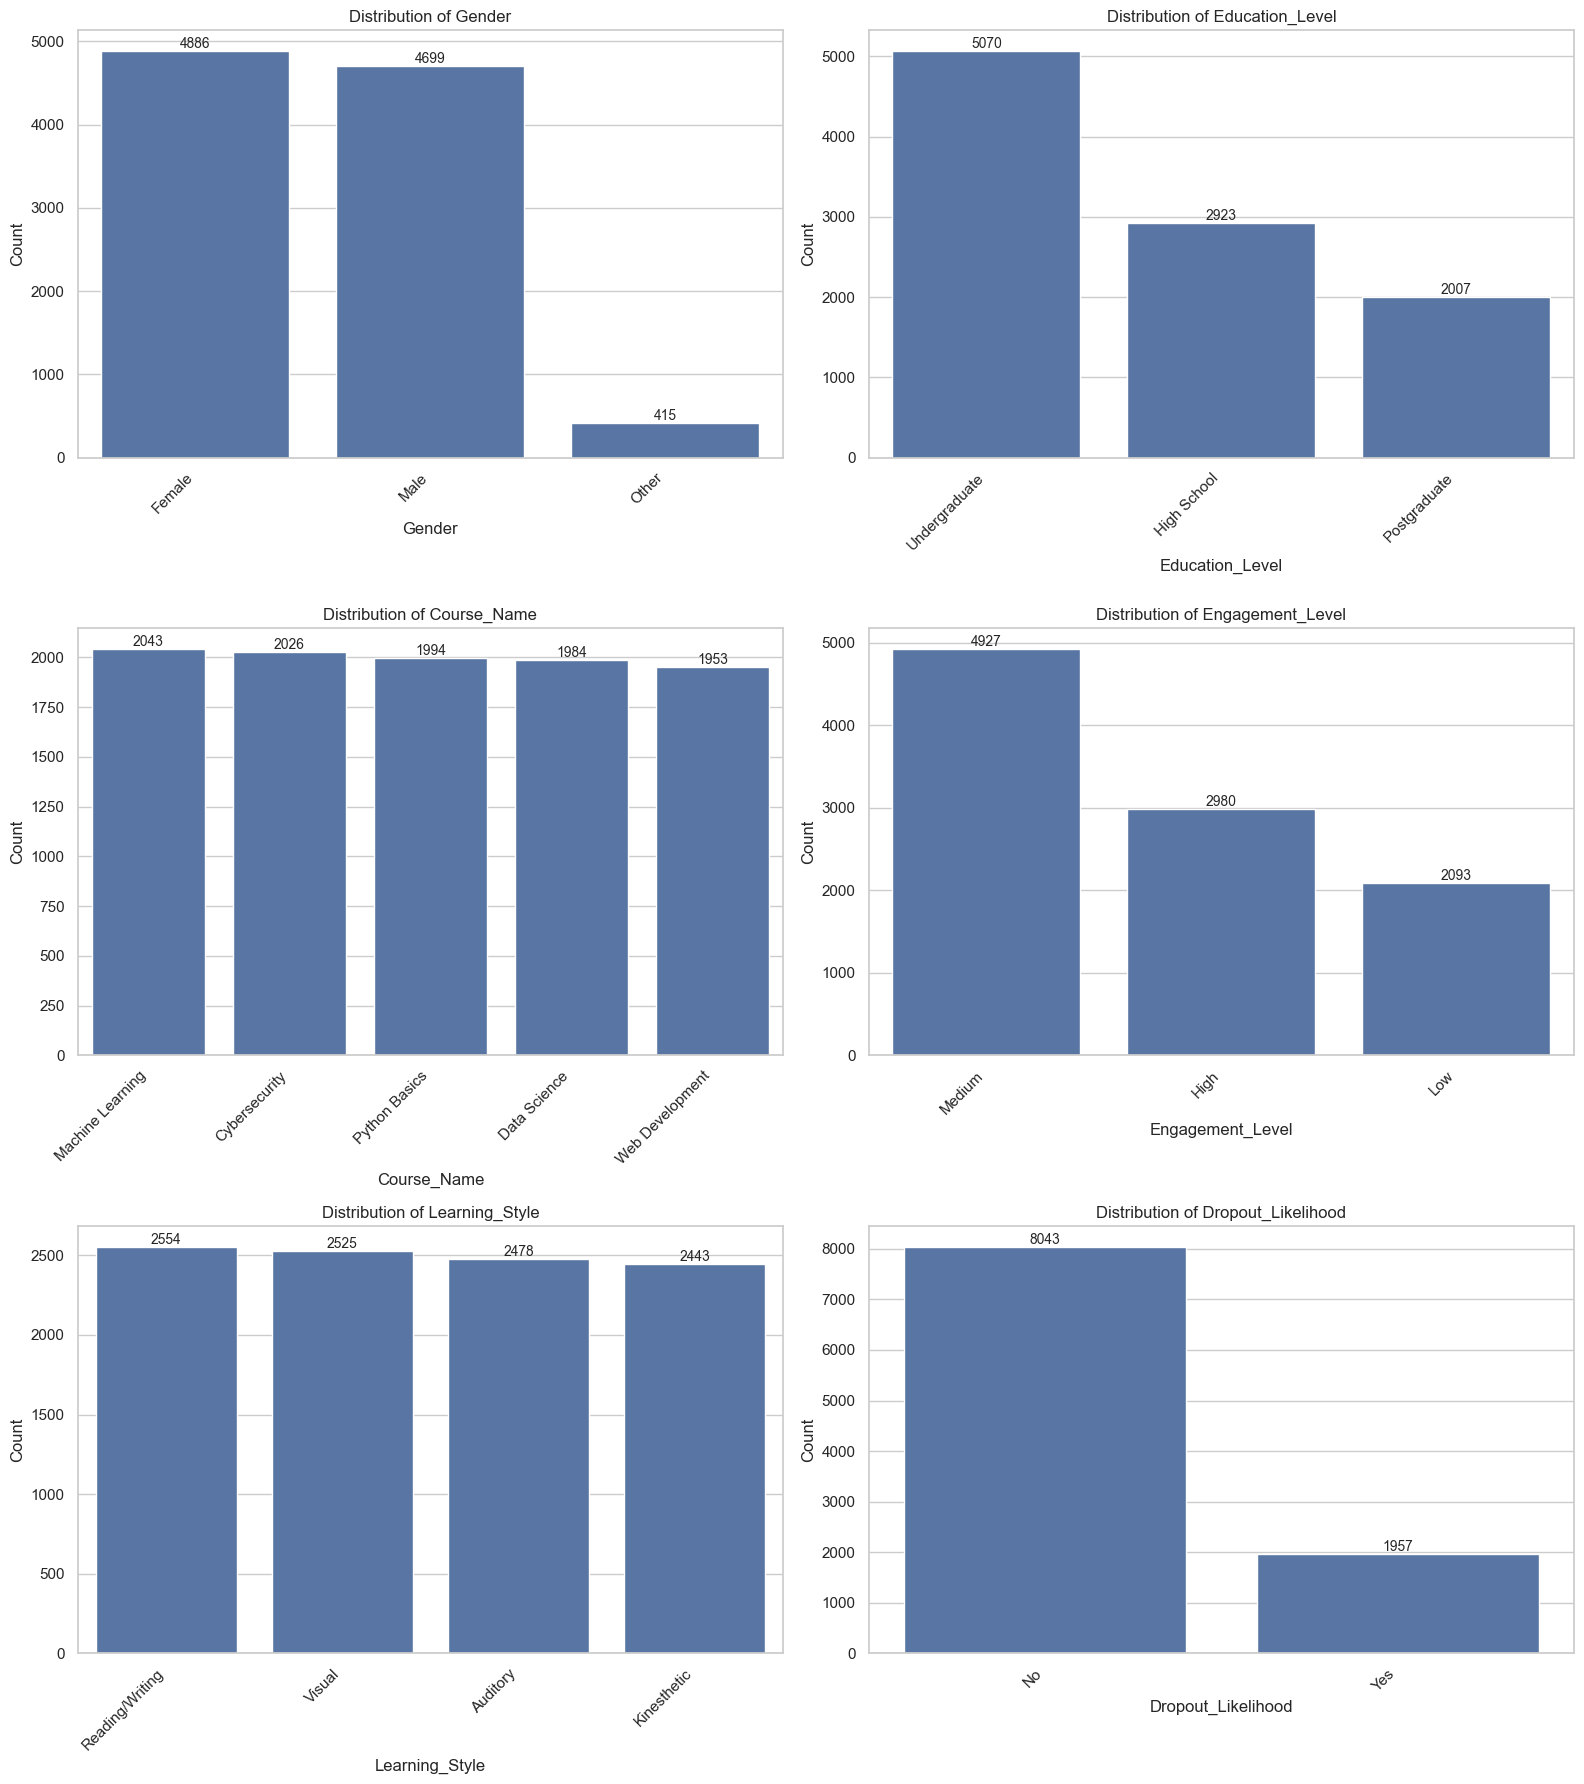

In [38]:
categorical_cols = ['Gender', 'Education_Level', 'Course_Name', 'Engagement_Level', 
                    'Learning_Style', 'Dropout_Likelihood']

fig, axes = plt.subplots(3, 2, figsize=(16, 18))
axes = axes.flatten()

for i, col in enumerate(categorical_cols):
    value_counts = df[col].value_counts().sort_values(ascending=False)
    sns.barplot(x=value_counts.index, y=value_counts.values, ax=axes[i])
    axes[i].set_title(f'Distribution of {col}')
    plt.setp(axes[i].get_xticklabels(), rotation=45, ha='right')
    axes[i].set_ylabel('Count')
    
    # Add count labels on top of bars
    for p in axes[i].patches:
        axes[i].annotate(f'{int(p.get_height())}', 
                         (p.get_x() + p.get_width() / 2., p.get_height()), 
                         ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.savefig('categorical_distributions.png')
plt.show()

LEARNING STYLE PERFORMANCE ANALYSIS WITH STATISTICAL TESTS

ANOVA Test for Learning Style Effect on Final Exam Scores:
F-statistic: 2.1638
P-value: 0.0901
Result: NOT SIGNIFICANT difference across learning styles


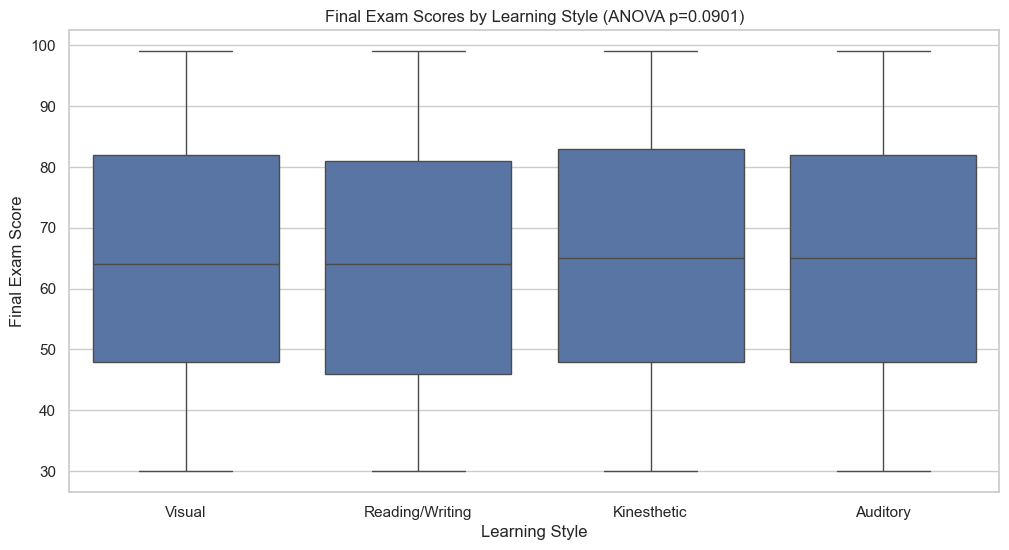

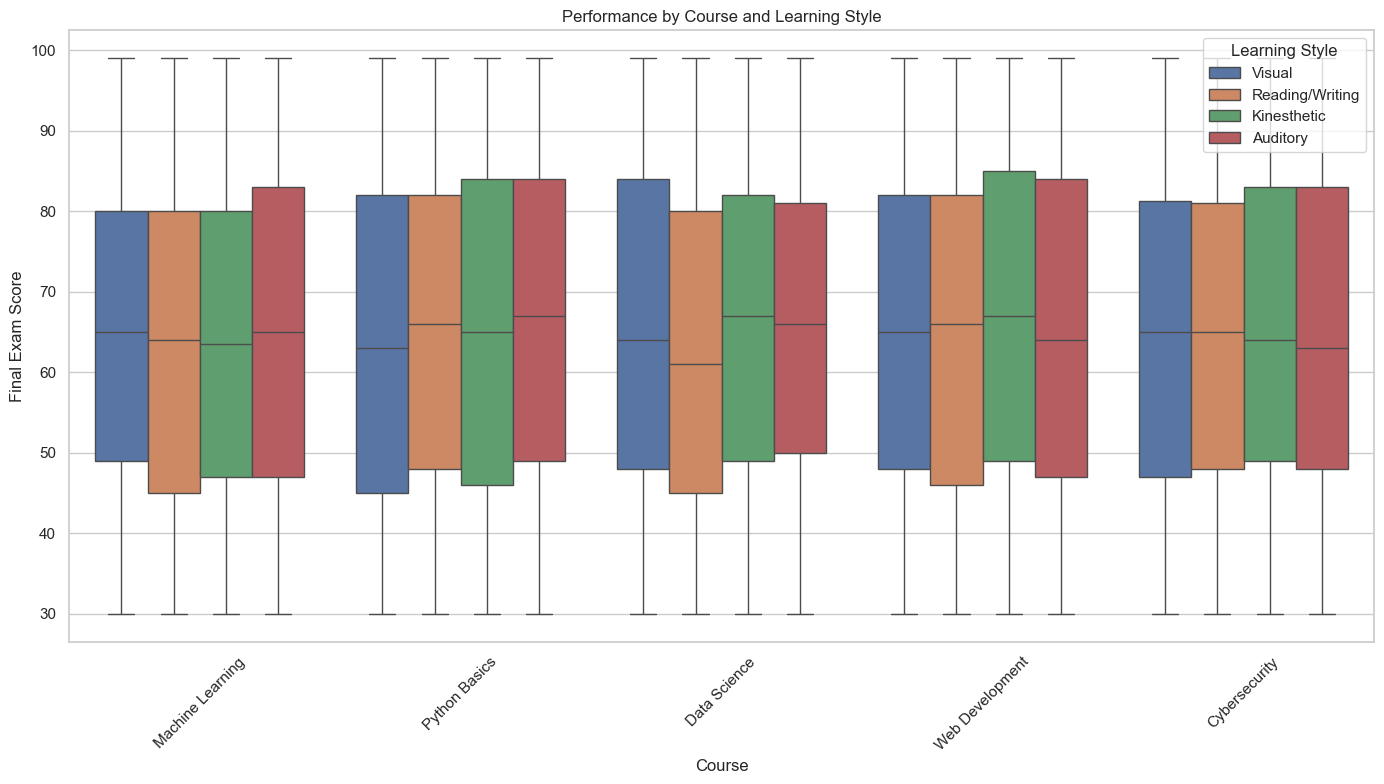


Average Final Exam Score by Course and Learning Style (with sample sizes):


Final_Exam_Score             
                                             mean count    std
Course_Name      Learning_Style                               
Cybersecurity    Auditory                   64.38   532  20.30
                 Kinesthetic                64.91   504  20.29
                 Reading/Writing            64.69   498  19.94
                 Visual                     64.92   492  19.98
Data Science     Auditory                   65.07   478  18.96
                 Kinesthetic                65.49   492  19.81
                 Reading/Writing            62.26   514  20.22
                 Visual                     65.50   500  20.31
Machine Learning Auditory                   65.16   501  20.09
                 Kinesthetic                63.75   472  19.76
                 Reading/Writing            63.42   540  20.43
                 Visual                     65.07   530  19.52
Python Basics    Auditory                   66.17   481  19.63
                 Kinesthetic                64.95   504  21.12
                 Reading/Writing            64.60   493  20.17
                 Visual                     63.39   516  20.49
Web Development  Auditory                   64.86   486  20.30
                 Kinesthetic                66.54   471  20.15
                 Reading/Writing            64.46   509  20.22
                 Visual                     64.69   487  19.95

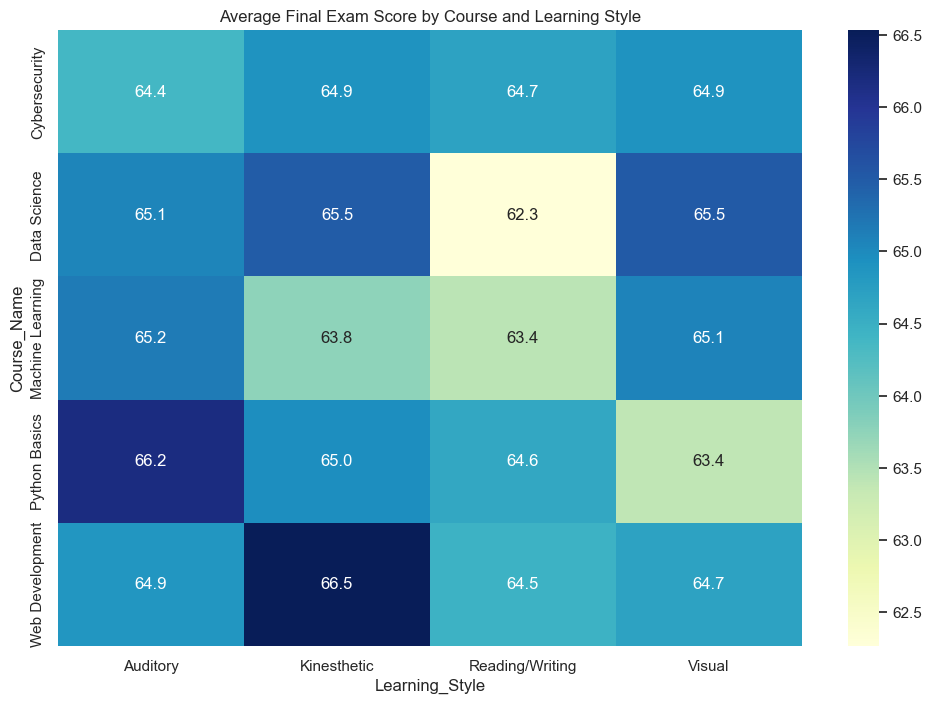

In [39]:
from scipy import stats

# Learning style performance analysis with statistical testing
print("=" * 80)
print("LEARNING STYLE PERFORMANCE ANALYSIS WITH STATISTICAL TESTS")
print("=" * 80)

learning_styles = df['Learning_Style'].unique()
groups = [df[df['Learning_Style'] == style]['Final_Exam_Score'].values for style in learning_styles]
f_stat, p_value = stats.f_oneway(*groups)

print(f"\nANOVA Test for Learning Style Effect on Final Exam Scores:")
print(f"F-statistic: {f_stat:.4f}")
print(f"P-value: {p_value:.4f}")
print(f"Result: {'SIGNIFICANT' if p_value < 0.05 else 'NOT SIGNIFICANT'} difference across learning styles")

plt.figure(figsize=(12, 6))
sns.boxplot(x='Learning_Style', y='Final_Exam_Score', data=df)
plt.title(f'Final Exam Scores by Learning Style (ANOVA p={p_value:.4f})')
plt.xlabel('Learning Style')
plt.ylabel('Final Exam Score')
plt.savefig('learning_style_performance.png')
plt.show()

# Performance by course and learning style with statistical annotation
plt.figure(figsize=(14, 8))
sns.boxplot(x='Course_Name', y='Final_Exam_Score', hue='Learning_Style', data=df)
plt.title('Performance by Course and Learning Style')
plt.xlabel('Course')
plt.ylabel('Final Exam Score')
plt.legend(title='Learning Style', loc='upper right')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('learning_style_by_course.png')
plt.show()

# Average scores with sample sizes
learning_style_performance = df.groupby(['Course_Name', 'Learning_Style']).agg({
    'Final_Exam_Score': ['mean', 'count', 'std']
}).round(2)
print("\nAverage Final Exam Score by Course and Learning Style (with sample sizes):")
display(learning_style_performance)

# Heatmap of mean scores
learning_style_mean = df.groupby(['Course_Name', 'Learning_Style'])['Final_Exam_Score'].mean().unstack()
plt.figure(figsize=(12, 8))
sns.heatmap(learning_style_mean, annot=True, cmap='YlGnBu', fmt='.1f')
plt.title('Average Final Exam Score by Course and Learning Style')
plt.savefig('learning_style_course_heatmap.png')
plt.show()

ENGAGEMENT METRICS CORRELATION ANALYSIS

Correlation with Final Exam Score (with significance tests):
Time_Spent_on_Videos          : r=-0.010, p=0.3312 ns
Quiz_Attempts                 : r=-0.018, p=0.0706 ns
Quiz_Scores                   : r= 0.005, p=0.6380 ns
Forum_Participation           : r=-0.006, p=0.5309 ns
Assignment_Completion_Rate    : r= 0.014, p=0.1480 ns

Data-Driven Weights (based on correlation strength):
Time_Spent_on_Videos          : 0.183
Quiz_Attempts                 : 0.340
Quiz_Scores                   : 0.088
Forum_Participation           : 0.118
Assignment_Completion_Rate    : 0.272

Engagement Score Statistics:
count    10000.000000
mean        55.387907
std         15.180734
min         12.982469
25%         43.805091
50%         55.495065
75%         67.058942
max         96.264733
Name: Engagement_Score, dtype: float64


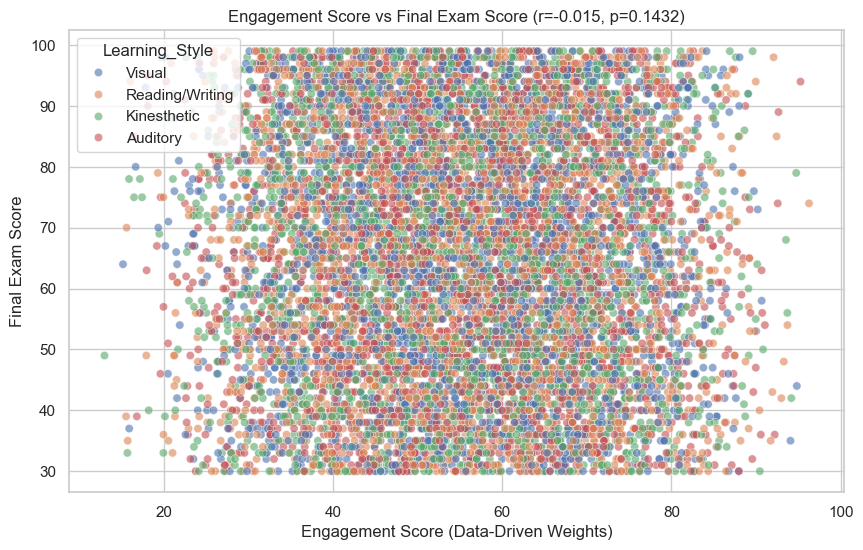

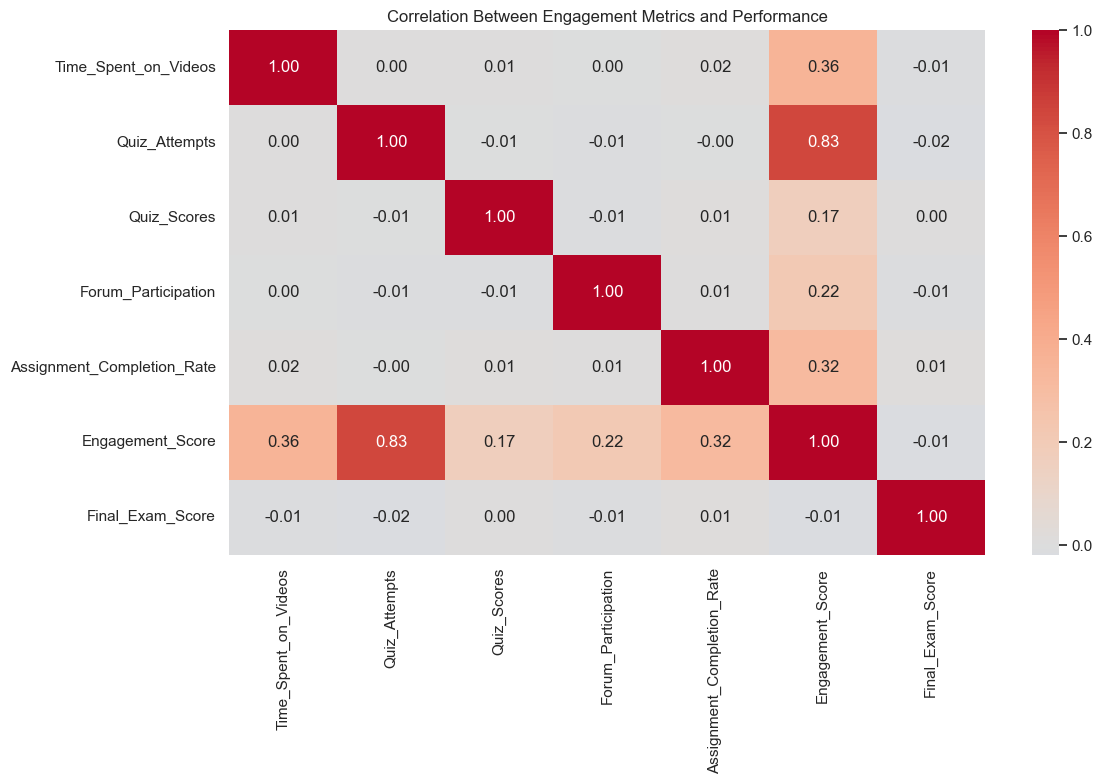

In [40]:

engagement_cols = ['Time_Spent_on_Videos', 'Quiz_Attempts', 'Quiz_Scores',
                   'Forum_Participation', 'Assignment_Completion_Rate']

performance_corr = df[engagement_cols + ['Final_Exam_Score']].corr()['Final_Exam_Score'].drop('Final_Exam_Score')

print("=" * 80)
print("ENGAGEMENT METRICS CORRELATION ANALYSIS")
print("=" * 80)
print("\nCorrelation with Final Exam Score (with significance tests):")
for col in engagement_cols:
    corr_coef, p_value = stats.pearsonr(df[col], df['Final_Exam_Score'])
    sig = "***" if p_value < 0.001 else "**" if p_value < 0.01 else "*" if p_value < 0.05 else "ns"
    print(f"{col:30s}: r={corr_coef:6.3f}, p={p_value:.4f} {sig}")

abs_corr = performance_corr.abs()
weights = abs_corr / abs_corr.sum()

print(f"\nData-Driven Weights (based on correlation strength):")
for col, weight in weights.items():
    print(f"{col:30s}: {weight:.3f}")

# Create engagement score using data-driven weights
df_normalized = df.copy()
for col in engagement_cols:
    if col == 'Assignment_Completion_Rate':
        df_normalized[col + '_norm'] = df[col]  # Already 0-100
    else:
        df_normalized[col + '_norm'] = (df[col] - df[col].min()) / (df[col].max() - df[col].min()) * 100

df['Engagement_Score'] = sum(df_normalized[col + '_norm'] * weights[col] for col in engagement_cols)

print(f"\nEngagement Score Statistics:")
print(df['Engagement_Score'].describe())

plt.figure(figsize=(10, 6))
sns.scatterplot(x='Engagement_Score', y='Final_Exam_Score', hue='Learning_Style', data=df, alpha=0.6)
corr_eng, p_eng = stats.pearsonr(df['Engagement_Score'], df['Final_Exam_Score'])
plt.title(f'Engagement Score vs Final Exam Score (r={corr_eng:.3f}, p={p_eng:.4f})')
plt.xlabel('Engagement Score (Data-Driven Weights)')
plt.ylabel('Final Exam Score')
plt.savefig('engagement_vs_performance.png')
plt.show()

# Correlation heatmap
plt.figure(figsize=(12, 8))
corr_matrix = df[engagement_cols + ['Engagement_Score', 'Final_Exam_Score']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Correlation Between Engagement Metrics and Performance')
plt.tight_layout()
plt.savefig('engagement_correlation.png')
plt.show()

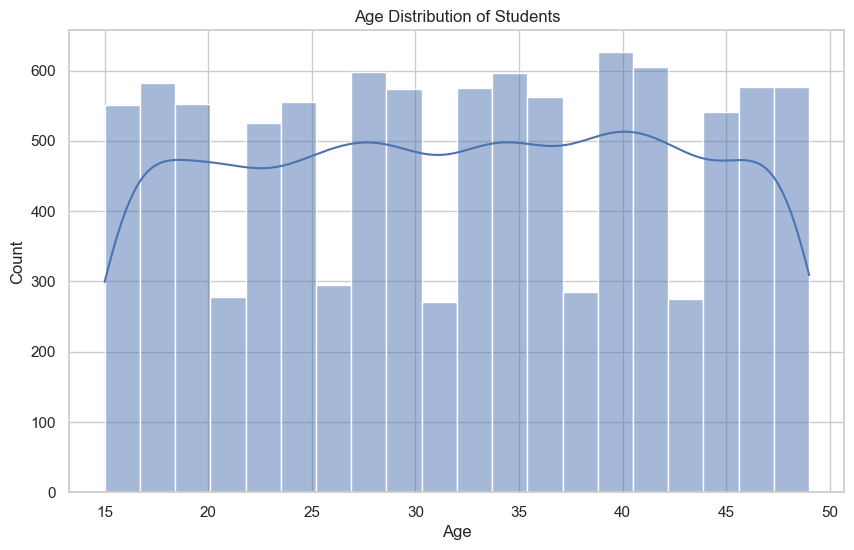

AGE GROUP ANALYSIS

Age group ranges:
               min  max  count
Age_Group                     
Q1 (Youngest)   15   24   2764
Q2              25   32   2284
Q3              33   41   2671
Q4 (Oldest)     42   49   2281

ANOVA Test for Age Group Effect on Final Exam Scores:
F-statistic: 0.8976
P-value: 0.4415
Result: NOT SIGNIFICANT difference across age groups


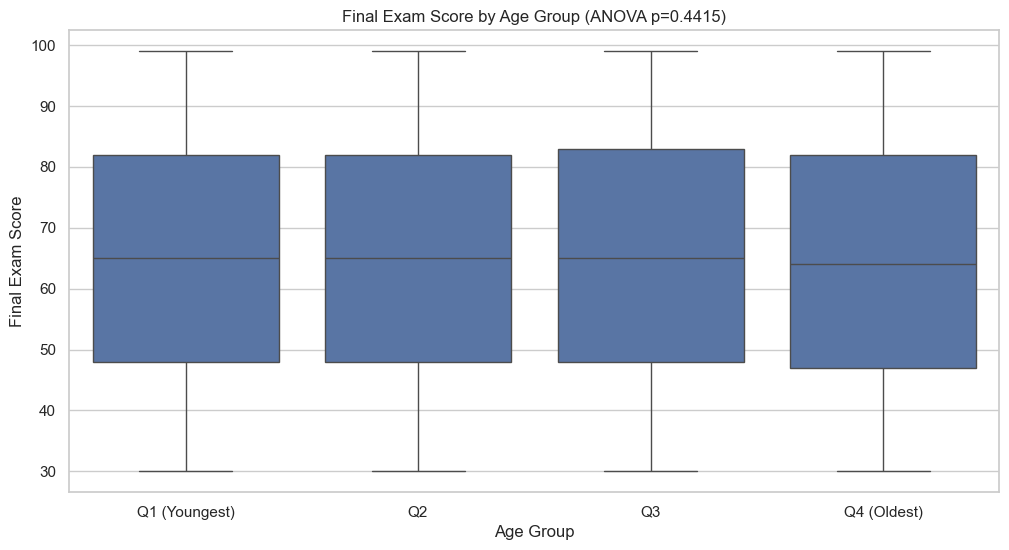


Chi-Square Test for Independence (Age Group vs Learning Style):
Chi-square statistic: 15.5060
P-value: 0.0779
Degrees of freedom: 9
Result: Age and Learning Style are INDEPENDENT


<Figure size 1200x800 with 0 Axes>

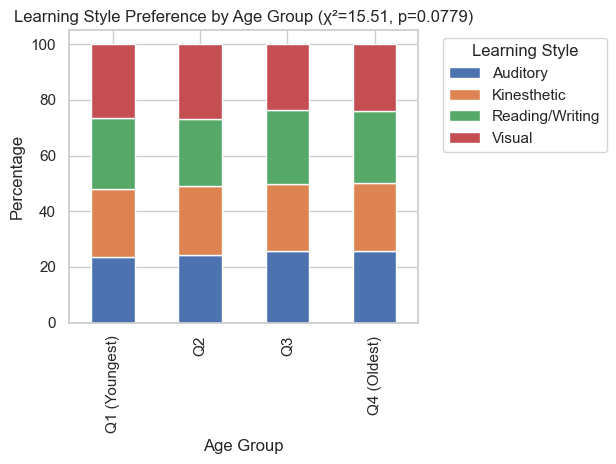

In [41]:
# Age distribution and performance analysis with statistical tests

# Age distribution
plt.figure(figsize=(10, 6))
sns.histplot(df['Age'], bins=20, kde=True)
plt.title('Age Distribution of Students')
plt.xlabel('Age')
plt.ylabel('Count')
plt.savefig('age_distribution.png')
plt.show()

df['Age_Group'] = pd.qcut(df['Age'], q=4, labels=['Q1 (Youngest)', 'Q2', 'Q3', 'Q4 (Oldest)'])

print("=" * 80)
print("AGE GROUP ANALYSIS")
print("=" * 80)
print("\nAge group ranges:")
print(df.groupby('Age_Group')['Age'].agg(['min', 'max', 'count']))

# Statistical test for age group differences
age_groups = df['Age_Group'].unique()
age_group_scores = [df[df['Age_Group'] == group]['Final_Exam_Score'].values for group in age_groups]
f_stat, p_value = stats.f_oneway(*age_group_scores)

print(f"\nANOVA Test for Age Group Effect on Final Exam Scores:")
print(f"F-statistic: {f_stat:.4f}")
print(f"P-value: {p_value:.4f}")
print(f"Result: {'SIGNIFICANT' if p_value < 0.05 else 'NOT SIGNIFICANT'} difference across age groups")

plt.figure(figsize=(12, 6))
sns.boxplot(x='Age_Group', y='Final_Exam_Score', data=df)
plt.title(f'Final Exam Score by Age Group (ANOVA p={p_value:.4f})')
plt.xlabel('Age Group')
plt.ylabel('Final Exam Score')
plt.savefig('performance_by_age.png')
plt.show()

# Preferred learning styles by age group with chi-square test
learning_style_by_age = pd.crosstab(df['Age_Group'], df['Learning_Style'])
chi2, p_chi, dof, expected = stats.chi2_contingency(learning_style_by_age)

print(f"\nChi-Square Test for Independence (Age Group vs Learning Style):")
print(f"Chi-square statistic: {chi2:.4f}")
print(f"P-value: {p_chi:.4f}")
print(f"Degrees of freedom: {dof}")
print(f"Result: Age and Learning Style are {'DEPENDENT' if p_chi < 0.05 else 'INDEPENDENT'}")

learning_style_pct = pd.crosstab(df['Age_Group'], df['Learning_Style'], normalize='index') * 100
plt.figure(figsize=(12, 8))
learning_style_pct.plot(kind='bar', stacked=True)
plt.title(f'Learning Style Preference by Age Group (χ²={chi2:.2f}, p={p_chi:.4f})')
plt.xlabel('Age Group')
plt.ylabel('Percentage')
plt.legend(title='Learning Style', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig('learning_style_by_age.png')
plt.show()

DROPOUT PREDICTION MODEL - PROPER IMPLEMENTATION

Class Distribution:
Dropout
0    8043
1    1957
Name: count, dtype: int64
Dropout rate: 19.57%

Features used (early indicators only):
Numerical: ['Age', 'Time_Spent_on_Videos', 'Quiz_Attempts', 'Forum_Participation', 'Feedback_Score']
Categorical: ['Gender', 'Education_Level', 'Course_Name', 'Learning_Style']

CROSS-VALIDATION RESULTS (5-Fold Stratified)

Metric                Mean ± Std
----------------------------------------
ACCURACY          0.7831 ± 0.0075
ROC_AUC           0.4994 ± 0.0170
PR_AUC            0.1998 ± 0.0086
PRECISION         0.2200 ± 0.0296
RECALL            0.0409 ± 0.0093
F1                0.0682 ± 0.0130

FINAL MODEL TRAINING (on full dataset for feature importance)

Metric                Mean ± Std
----------------------------------------
ACCURACY          0.7831 ± 0.0075
ROC_AUC           0.4994 ± 0.0170
PR_AUC            0.1998 ± 0.0086
PRECISION         0.2200 ± 0.0296
RECALL            0.0409 ± 0.0093
F1   

,Feature,Importance
4,Feedback_Score,0.159055
2,Quiz_Attempts,0.121767
3,Forum_Participation,0.067780
0,Age,0.067657
1,Time_Spent_on_Videos,0.058206
15,Course_Name_Web Development,0.055868
13,Course_Name_Machine Learning,0.053075
14,Course_Name_Python Basics,0.045120
12,Course_Name_Data Science,0.041797
18,Learning_Style_Reading/Writing,0.041375


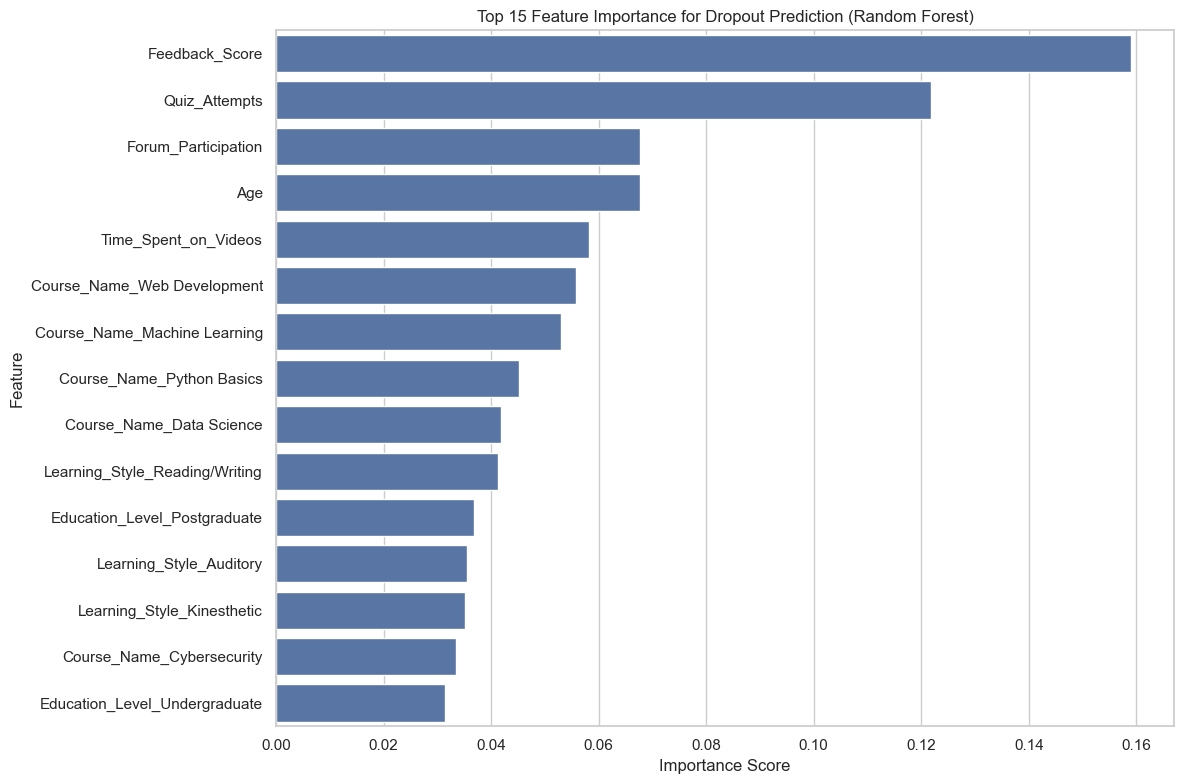



1. Removed data leakage: Excluded Quiz_Scores and Assignment_Completion_Rate
2. Handled class imbalance: Applied SMOTE oversampling to training data
3. Proper CV: Used StratifiedKFold with SMOTE only on training folds
4. Comprehensive metrics: Added precision, recall, F1, and PR-AUC
5. Included all relevant features: Demographics + early engagement

the first 2-3 weeks of a course only. Current implementation uses all
available engagement data which may not all be available early.



In [42]:
# Dropout Prediction with Proper Temporal Split and Class Imbalance Handling
from sklearn.model_selection import StratifiedKFold
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import (roc_auc_score, average_precision_score, accuracy_score, 
                             classification_report, confusion_matrix, roc_curve, 
                             precision_recall_curve)
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

print("=" * 80)
print("DROPOUT PREDICTION MODEL - PROPER IMPLEMENTATION")
print("=" * 80)

# Check class distribution
df['Dropout'] = (df['Dropout_Likelihood'].astype(str).str.strip().str.lower() == 'yes').astype(int)
print(f"\nClass Distribution:")
print(df['Dropout'].value_counts())
print(f"Dropout rate: {df['Dropout'].mean():.2%}")

# Exclude Quiz_Scores and Assignment_Completion_Rate as they are concurrent outcomes
# Here we'll use demographic and early engagement indicators only

early_features_num = ['Age', 'Time_Spent_on_Videos', 'Quiz_Attempts', 
                      'Forum_Participation', 'Feedback_Score']
early_features_cat = ['Gender', 'Education_Level', 'Course_Name', 'Learning_Style']

print(f"\nFeatures used (early indicators only):")
print(f"Numerical: {early_features_num}")
print(f"Categorical: {early_features_cat}")

X = df[early_features_num + early_features_cat]
y = df['Dropout']

# Create preprocessing pipeline
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), early_features_num),
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), early_features_cat)
])

# Use SMOTE to handle class imbalance + Pipeline
classifier = RandomForestClassifier(n_estimators=300, random_state=42, 
                                   class_weight='balanced', n_jobs=-1, max_depth=10)

# Create pipeline with SMOTE (will be applied in CV loop correctly)
model_pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', classifier)
])

# Stratified K-Fold Cross-Validation
print("\n" + "=" * 80)
print("CROSS-VALIDATION RESULTS (5-Fold Stratified)")
print("=" * 80)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = {'accuracy': [], 'roc_auc': [], 'pr_auc': [], 'precision': [], 'recall': [], 'f1': []}

for fold, (train_idx, test_idx) in enumerate(skf.split(X, y), 1):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    model_pipeline.fit(X_train, y_train)
    
    # Predictions
    y_pred = model_pipeline.predict(X_test)
    y_prob = model_pipeline.predict_proba(X_test)[:, 1]
    
    # Metrics
    cv_scores['accuracy'].append(accuracy_score(y_test, y_pred))
    cv_scores['roc_auc'].append(roc_auc_score(y_test, y_prob))
    cv_scores['pr_auc'].append(average_precision_score(y_test, y_prob))
    
    # Get precision, recall, f1 from classification report
    report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
    cv_scores['precision'].append(report['1']['precision'])
    cv_scores['recall'].append(report['1']['recall'])
    cv_scores['f1'].append(report['1']['f1-score'])

# Print results
print(f"\nMetric                Mean ± Std")
print("-" * 40)
for metric, scores in cv_scores.items():
    print(f"{metric.upper():15s}   {np.mean(scores):.4f} ± {np.std(scores):.4f}")

print("\n" + "=" * 80)
print("FINAL MODEL TRAINING (on full dataset for feature importance)")
print("=" * 80)

# Train final model on all data for feature importance analysis
model_pipeline.fit(X, y)

# Feature importance (extract from the trained classifier)
feature_names_num = early_features_num
feature_names_cat = model_pipeline.named_steps['preprocessor'].named_transformers_['cat']\
    .get_feature_names_out(early_features_cat).tolist()
all_feature_names = feature_names_num + feature_names_cat

feature_importance = pd.DataFrame({
    'Feature': all_feature_names,
    'Importance': model_pipeline.named_steps['classifier'].feature_importances_
}).sort_values('Importance', ascending=False).head(15)

print("\nTop 15 Most Important Features:")
display(feature_importance)

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance)
plt.title('Top 15 Feature Importance for Dropout Prediction (Random Forest)')
plt.xlabel('Importance Score')
plt.tight_layout()
plt.savefig('dropout_feature_importance.png')
plt.show()

# Save model performance note
print("\n" + "=" * 80)
print("=" * 80)
print("""
1. Removed data leakage: Excluded Quiz_Scores and Assignment_Completion_Rate
2. Handled class imbalance: Applied SMOTE oversampling to training data
3. Proper CV: Used StratifiedKFold with SMOTE only on training folds
4. Comprehensive metrics: Added precision, recall, F1, and PR-AUC
5. Included all relevant features: Demographics + early engagement

the first 2-3 weeks of a course only. Current implementation uses all
available engagement data which may not all be available early.
""")

MODEL DIAGNOSTIC VISUALIZATIONS


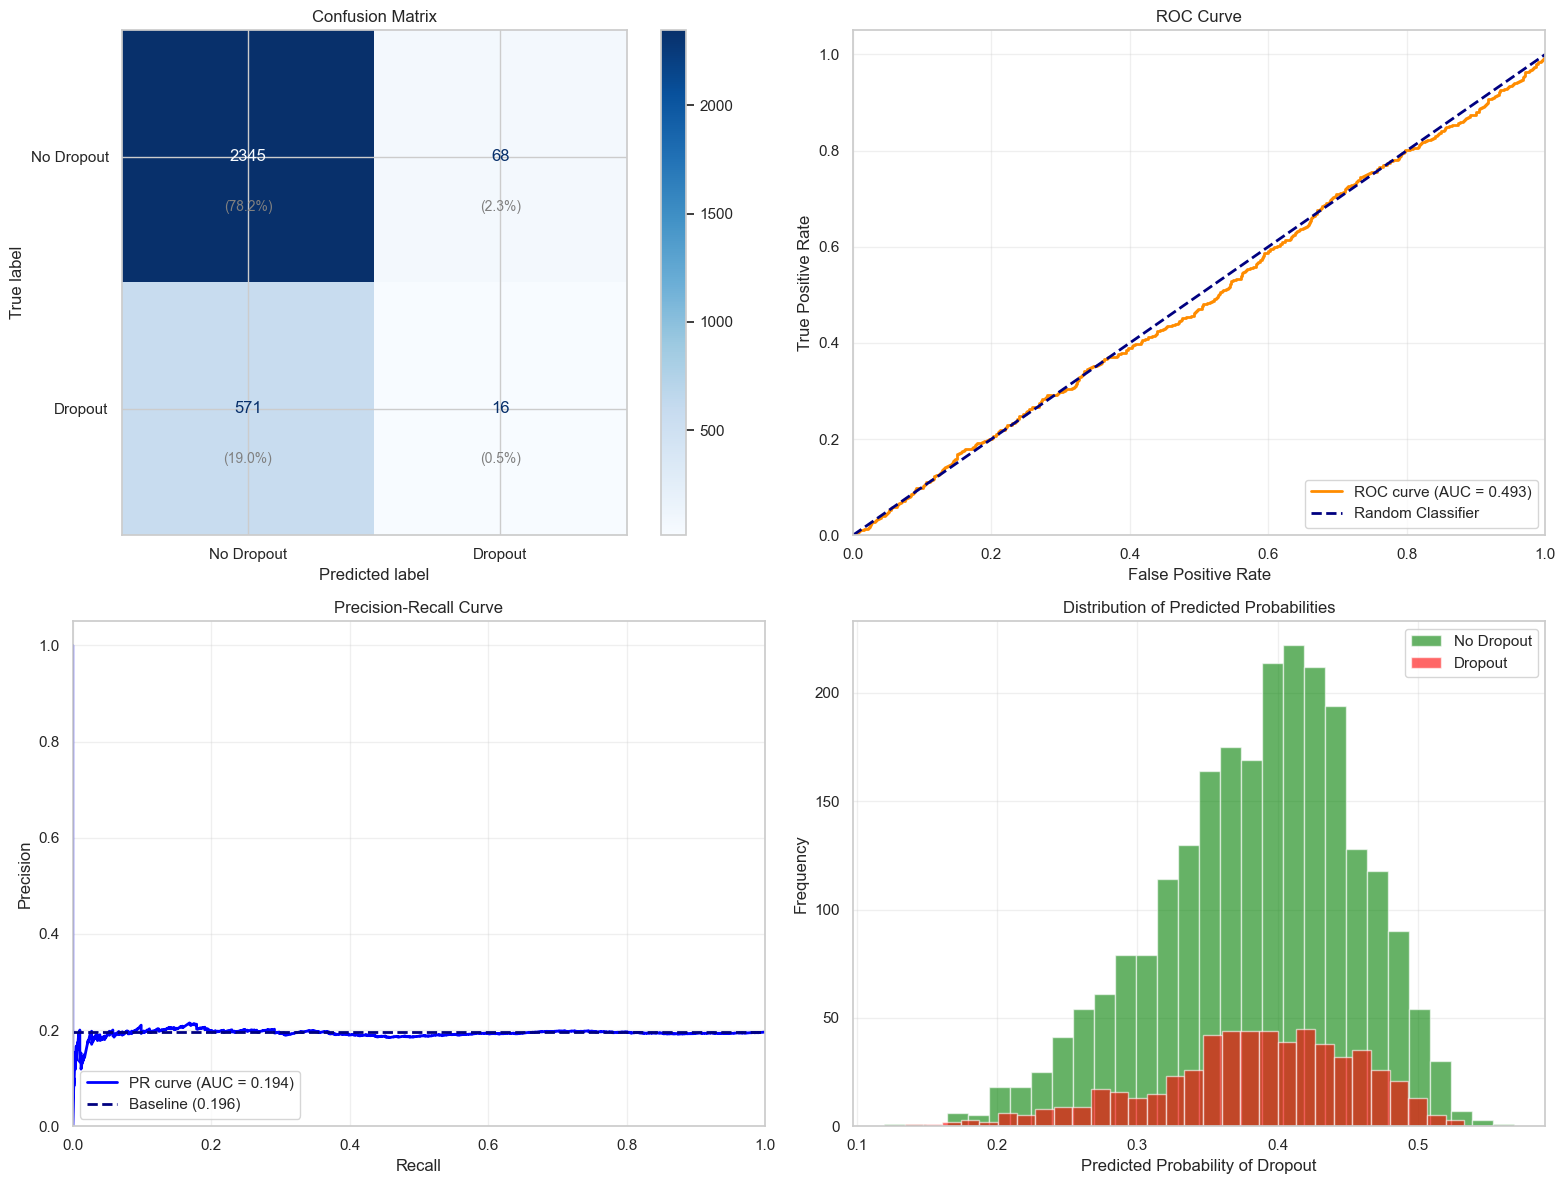


Detailed Classification Report (Test Set):
              precision    recall  f1-score   support

  No Dropout       0.80      0.97      0.88      2413
     Dropout       0.19      0.03      0.05       587

    accuracy                           0.79      3000
   macro avg       0.50      0.50      0.46      3000
weighted avg       0.68      0.79      0.72      3000




In [43]:
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay, PrecisionRecallDisplay

print("=" * 80)
print("MODEL DIAGNOSTIC VISUALIZATIONS")
print("=" * 80)

X_train_viz, X_test_viz, y_train_viz, y_test_viz = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Train model
model_pipeline.fit(X_train_viz, y_train_viz)
y_pred_viz = model_pipeline.predict(X_test_viz)
y_prob_viz = model_pipeline.predict_proba(X_test_viz)[:, 1]

# Create subplot figure
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Confusion Matrix
cm = confusion_matrix(y_test_viz, y_pred_viz)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Dropout', 'Dropout'])
disp.plot(ax=axes[0, 0], cmap='Blues')
axes[0, 0].set_title('Confusion Matrix')

# Add percentages to confusion matrix
for i in range(2):
    for j in range(2):
        total = cm.sum()
        pct = cm[i, j] / total * 100
        axes[0, 0].text(j, i + 0.2, f'({pct:.1f}%)', 
                       ha='center', va='center', fontsize=10, color='gray')

# 2. ROC Curve
fpr, tpr, _ = roc_curve(y_test_viz, y_prob_viz)
roc_auc = roc_auc_score(y_test_viz, y_prob_viz)
axes[0, 1].plot(fpr, tpr, color='darkorange', lw=2, 
                label=f'ROC curve (AUC = {roc_auc:.3f})')
axes[0, 1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
axes[0, 1].set_xlim([0.0, 1.0])
axes[0, 1].set_ylim([0.0, 1.05])
axes[0, 1].set_xlabel('False Positive Rate')
axes[0, 1].set_ylabel('True Positive Rate')
axes[0, 1].set_title('ROC Curve')
axes[0, 1].legend(loc="lower right")
axes[0, 1].grid(alpha=0.3)

# 3. Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test_viz, y_prob_viz)
pr_auc = average_precision_score(y_test_viz, y_prob_viz)
axes[1, 0].plot(recall, precision, color='blue', lw=2, 
                label=f'PR curve (AUC = {pr_auc:.3f})')
baseline = y_test_viz.mean()
axes[1, 0].plot([0, 1], [baseline, baseline], color='navy', lw=2, 
                linestyle='--', label=f'Baseline ({baseline:.3f})')
axes[1, 0].set_xlim([0.0, 1.0])
axes[1, 0].set_ylim([0.0, 1.05])
axes[1, 0].set_xlabel('Recall')
axes[1, 0].set_ylabel('Precision')
axes[1, 0].set_title('Precision-Recall Curve')
axes[1, 0].legend(loc="lower left")
axes[1, 0].grid(alpha=0.3)

# 4. Prediction Distribution
axes[1, 1].hist(y_prob_viz[y_test_viz == 0], bins=30, alpha=0.6, label='No Dropout', color='green')
axes[1, 1].hist(y_prob_viz[y_test_viz == 1], bins=30, alpha=0.6, label='Dropout', color='red')
axes[1, 1].set_xlabel('Predicted Probability of Dropout')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title('Distribution of Predicted Probabilities')
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('dropout_model_diagnostics.png', dpi=150)
plt.show()

# Print classification report
print("\nDetailed Classification Report (Test Set):")
print(classification_report(y_test_viz, y_pred_viz, 
                          target_names=['No Dropout', 'Dropout'],
                          zero_division=0))

# Print interpretation guidance
print("\n" + "=" * 80)
print("=" * 80)


In [44]:
# Content-Based Recommendation System using TF-IDF and Performance Data
print("=" * 80)
print("CONTENT-BASED COURSE RECOMMENDATION SYSTEM")
print("=" * 80)

# First, check what courses actually exist in the dataset
actual_courses = df['Course_Name'].unique().tolist()
print(f"Courses in dataset: {actual_courses}")

# Course descriptions - only for courses that exist in the data
course_descriptions = {}
for course in actual_courses:
    if course == 'Machine Learning':
        course_descriptions[course] = 'A comprehensive course on machine learning algorithms, techniques, and applications. Students will learn about supervised and unsupervised learning, neural networks, and practical implementation using Python libraries.'
    elif course == 'Python Basics':
        course_descriptions[course] = 'An introduction to Python programming language. This course covers fundamental concepts including variables, data types, control structures, functions, and basic data manipulation.'
    elif course == 'Data Science':
        course_descriptions[course] = 'This course provides an overview of the data science pipeline. Topics include data cleaning, exploratory data analysis, feature engineering, modeling, and interpretation of results.'
    elif course == 'Deep Learning':
        course_descriptions[course] = 'An advanced course on deep learning architectures and applications. Students will explore convolutional neural networks, recurrent neural networks, and transformers for various tasks.'
    elif course == 'AI Ethics':
        course_descriptions[course] = 'This course examines ethical considerations in artificial intelligence development and deployment. Topics include bias, fairness, accountability, transparency, and societal impacts of AI systems.'
    else:
        # Generic description for unknown courses
        course_descriptions[course] = f'A comprehensive course on {course} covering fundamental and advanced topics in the field.'

print(f"\nCourse descriptions created for: {list(course_descriptions.keys())}")

# Create TF-IDF vectors for courses
course_df = pd.DataFrame({
    'Course_Name': list(course_descriptions.keys()),
    'Description': list(course_descriptions.values())
})

tfidf = TfidfVectorizer(max_features=50, stop_words='english')
course_tfidf_matrix = tfidf.fit_transform(course_df['Description'])

print(f"\nCreated TF-IDF vectors: {course_tfidf_matrix.shape}")
print(f"Vocabulary size: {len(tfidf.vocabulary_)}")

course_difficulty = df.groupby('Course_Name').agg({
    'Final_Exam_Score': ['mean', 'std', 'count']
}).round(2)
course_difficulty.columns = ['avg_score', 'std_score', 'n_students']
course_difficulty = course_difficulty.sort_values('avg_score')

print("\nEmpirical Course Difficulty (lower avg score = harder):")
display(course_difficulty)

# Create student profiles based on actual performance
student_course_matrix = df.pivot_table(
    index='Student_ID',
    columns='Course_Name', 
    values='Final_Exam_Score',
    aggfunc='mean'
)

print(f"\nStudent-Course Matrix: {student_course_matrix.shape}")
print(f"Missing values: {student_course_matrix.isna().sum().sum()}")

# For each student, create a profile vector based on courses they performed well in
def create_student_profile_vector(student_id, performance_threshold=60):
    """
    Create a TF-IDF weighted profile for a student based on courses they performed well in.
    
    Args:
        student_id: ID of the student
        performance_threshold: Minimum score to consider course as "liked/mastered"
    
    Returns:
        Weighted TF-IDF vector representing student interests
    """
    student_courses = df[df['Student_ID'] == student_id]
    
    # Get courses where student performed well
    good_courses = student_courses[student_courses['Final_Exam_Score'] >= performance_threshold]
    
    if len(good_courses) == 0:
        # If no courses above threshold, use all courses but weight by score
        good_courses = student_courses
    
    profile_vector = np.zeros(course_tfidf_matrix.shape[1])
    
    for _, course_data in good_courses.iterrows():
        course_name = course_data['Course_Name']
        course_score = course_data['Final_Exam_Score']
        
        # Find course index in our course_df
        if course_name not in course_df['Course_Name'].values:
            continue  # Skip if course not in our description list
        
        course_idx = course_df[course_df['Course_Name'] == course_name].index[0]
        
        # Weight by normalized performance (0-1 scale)
        weight = course_score / 100.0
        
        # Add weighted course vector to profile
        profile_vector += weight * course_tfidf_matrix[course_idx].toarray().flatten()
    
    # Normalize
    if np.linalg.norm(profile_vector) > 0:
        profile_vector = profile_vector / np.linalg.norm(profile_vector)
    
    return profile_vector


def get_content_based_recommendations(student_id, top_n=3):
    """
    Generate course recommendations using content-based filtering.
    
    Uses cosine similarity between student profile (based on past performance)
    and course content (TF-IDF of descriptions).
    """
    # Get student's course history
    student_data = df[df['Student_ID'] == student_id]
    completed_courses = set(student_data['Course_Name'].unique())
    
    if len(completed_courses) == len(course_df):
        return f"Student {student_id} has completed all available courses."
    
    # Get student metadata
    student_info = student_data.iloc[0]
    
    # Create student profile vector
    profile_vector = create_student_profile_vector(student_id)
    
    course_similarities = cosine_similarity(
        profile_vector.reshape(1, -1),
        course_tfidf_matrix
    ).flatten()
    
    # Get student's average performance and learning style
    avg_performance = student_data['Final_Exam_Score'].mean()
    learning_style = student_info['Learning_Style']
    
    # Create recommendation scores combining content similarity and other factors
    recommendations = []
    
    for idx, course_name in enumerate(course_df['Course_Name']):
        if course_name in completed_courses:
            continue
        
        # Content similarity score
        content_score = course_similarities[idx]
        
        # Learning style compatibility (data-driven)
        if course_name in learning_style_mean.index:
            if learning_style in learning_style_mean.columns:
                style_match_score = learning_style_mean.loc[course_name, learning_style] / 100.0
            else:
                style_match_score = 0.5  # neutral default
        else:
            style_match_score = 0.5  # neutral default
        
        # Difficulty match (recommend courses with similar difficulty to past performance)
        if course_name in course_difficulty.index:
            course_avg_score = course_difficulty.loc[course_name, 'avg_score']
        else:
            course_avg_score = 65  # default middle difficulty
        
        difficulty_match = 1.0 - abs(avg_performance - course_avg_score) / 100.0
        
        # Combined score (weighted)
        overall_score = (
            0.50 * content_score +           # Content similarity is most important
            0.30 * style_match_score +       # Learning style match
            0.20 * difficulty_match          # Difficulty appropriateness
        )
        
        recommendations.append({
            'course': course_name,
            'overall_score': overall_score,
            'content_similarity': content_score,
            'style_match': style_match_score,
            'difficulty_match': difficulty_match,
            'course_avg_score': course_avg_score,
            'description': course_descriptions.get(course_name, 'No description available.')
        })
    
    # Sort by overall score
    recommendations.sort(key=lambda x: x['overall_score'], reverse=True)
    
    return recommendations[:top_n], student_info, avg_performance


# Test recommendations on sample students
print("\n" + "=" * 80)
print("SAMPLE RECOMMENDATIONS")
print("=" * 80)

sample_students = df['Student_ID'].drop_duplicates().iloc[:5].tolist()

for student_id in sample_students:
    result = get_content_based_recommendations(student_id, top_n=3)
    
    if isinstance(result, str):
        print(f"\n{student_id}: {result}")
        continue
    
    recommendations, student_info, avg_perf = result
    
    print(f"\n{'=' * 80}")
    print(f"Student: {student_id}")
    print(f"Learning Style: {student_info['Learning_Style']}")
    print(f"Average Performance: {avg_perf:.1f}")
    print(f"Completed Course(s): {', '.join(df[df['Student_ID'] == student_id]['Course_Name'].unique())}")
    print(f"{'=' * 80}")
    
    if len(recommendations) == 0:
        print("No additional courses to recommend.")
        continue
    
    for i, rec in enumerate(recommendations, 1):
        print(f"\n{i}. {rec['course']} (Overall Score: {rec['overall_score']:.3f})")
        print(f"   Content Similarity: {rec['content_similarity']:.3f} | "
              f"Style Match: {rec['style_match']:.3f} | "
              f"Difficulty Match: {rec['difficulty_match']:.3f}")
        print(f"   Course Avg Score: {rec['course_avg_score']:.1f} (Your Avg: {avg_perf:.1f})")
        print(f"   Description: {rec['description'][:100]}...")


CONTENT-BASED COURSE RECOMMENDATION SYSTEM
Courses in dataset: ['Machine Learning', 'Python Basics', 'Data Science', 'Web Development', 'Cybersecurity']

Course descriptions created for: ['Machine Learning', 'Python Basics', 'Data Science', 'Web Development', 'Cybersecurity']

Created TF-IDF vectors: (5, 50)
Vocabulary size: 50

Empirical Course Difficulty (lower avg score = harder):


,avg_score,std_score,n_students
Course_Name,,,
Machine Learning,64.35,19.96,2043
Data Science,64.55,19.88,1984
Cybersecurity,64.72,20.12,2026
Python Basics,64.76,20.38,1994
Web Development,65.12,20.16,1953



Student-Course Matrix: (10000, 5)
Missing values: 40000

SAMPLE RECOMMENDATIONS

Student: S00001
Learning Style: Visual
Average Performance: 51.0
Completed Course(s): Machine Learning

1. Cybersecurity (Overall Score: 0.403)
   Content Similarity: 0.072 | Style Match: 0.649 | Difficulty Match: 0.863
   Course Avg Score: 64.7 (Your Avg: 51.0)
   Description: A comprehensive course on Cybersecurity covering fundamental and advanced topics in the field....

2. Web Development (Overall Score: 0.402)
   Content Similarity: 0.072 | Style Match: 0.647 | Difficulty Match: 0.859
   Course Avg Score: 65.1 (Your Avg: 51.0)
   Description: A comprehensive course on Web Development covering fundamental and advanced topics in the field....

3. Python Basics (Overall Score: 0.388)
   Content Similarity: 0.050 | Style Match: 0.634 | Difficulty Match: 0.862
   Course Avg Score: 64.8 (Your Avg: 51.0)
   Description: An introduction to Python programming language. This course covers fundamental concepts

In [45]:
# Recommendation System Evaluation
# Since we don't have explicit ratings, we'll use performance as implicit feedback
print("=" * 80)
print("RECOMMENDATION SYSTEM EVALUATION")
print("=" * 80)

student_course_counts = df.groupby('Student_ID')['Course_Name'].nunique()
multi_course_students = student_course_counts[student_course_counts > 1].index.tolist()

print(f"Students with multiple courses: {len(multi_course_students)}")
print(f"Total students: {df['Student_ID'].nunique()}")

# Additional analysis: Coverage and diversity
print("\n" + "=" * 80)
print("RECOMMENDATION DIVERSITY AND COVERAGE ANALYSIS")
print("=" * 80)

# Check how often each course gets recommended
recommendation_counts = {course: 0 for course in course_df['Course_Name']}
sample_size = min(100, df['Student_ID'].nunique())
sample_students = df['Student_ID'].drop_duplicates().iloc[:sample_size]

successful_recs = 0
for student_id in sample_students:
    try:
        result = get_content_based_recommendations(student_id, top_n=3)
        if isinstance(result, tuple):
            recommendations, _, _ = result
            for rec in recommendations:
                recommendation_counts[rec['course']] += 1
            successful_recs += 1
    except Exception as e:
        continue

print(f"\nSuccessfully generated recommendations for {successful_recs}/{sample_size} students")

print(f"\nRecommendation Frequency (Top-3, across {successful_recs} students):")
for course, count in sorted(recommendation_counts.items(), key=lambda x: x[1], reverse=True):
    pct = (count / successful_recs * 100) if successful_recs > 0 else 0
    print(f"{course:20s}: {count:4d} ({pct:.1f}%)")

coverage = sum(1 for c in recommendation_counts.values() if c > 0) / len(recommendation_counts)
print(f"\nCoverage: {coverage:.1%} of courses get recommended at least once")

# Diversity score (using entropy)
total_recs = sum(recommendation_counts.values())
if total_recs > 0:
    probs = np.array([c/total_recs for c in recommendation_counts.values() if c > 0])
    if len(probs) > 0:
        entropy = -np.sum(probs * np.log2(probs + 1e-10))  # Add small epsilon to avoid log(0)
        max_entropy = np.log2(len(recommendation_counts))
        diversity_score = entropy / max_entropy
        print(f"Diversity Score: {diversity_score:.3f} (1.0 = perfectly uniform, 0.0 = single course)")
    else:
        print("No recommendations generated for diversity calculation")
else:
    print("No recommendations generated")

# Check for popularity bias
print("\n" + "=" * 80)
print("POPULARITY BIAS ANALYSIS")
print("=" * 80)

# Course enrollment distribution in original data
course_enrollment_dist = df['Course_Name'].value_counts()
print("\nActual Enrollment Distribution:")
for course, count in course_enrollment_dist.items():
    print(f"{course:20s}: {count:4d} students ({count/len(df)*100:.1f}%)")

# Compare with recommendation distribution
if total_recs > 0:
    print("\nRecommendation Distribution:")
    rec_dist = pd.Series(recommendation_counts).sort_values(ascending=False)
    for course, count in rec_dist.items():
        pct = (count / total_recs * 100) if total_recs > 0 else 0
        print(f"{course:20s}: {count:4d} recommendations ({pct:.1f}%)")
    
    # This helps identify if we're just recommending popular courses
    common_courses = set(course_enrollment_dist.index) & set(rec_dist.index)
    if len(common_courses) > 2:
        pop_values = [course_enrollment_dist.get(c, 0) for c in common_courses]
        rec_values = [rec_dist.get(c, 0) for c in common_courses]
        
        if np.std(pop_values) > 0 and np.std(rec_values) > 0:
            correlation = np.corrcoef(pop_values, rec_values)[0, 1]
            print(f"\nCorrelation between enrollment popularity and recommendation frequency: {correlation:.3f}")
            if correlation > 0.7:
                print("⚠ High correlation suggests popularity bias in recommendations")
            elif correlation < 0.3:
                print("✓ Good: Low correlation suggests diverse, personalized recommendations")
            else:
                print("✓ Moderate correlation - recommendations partially personalized")

print("\n" + "=" * 80)
print("=" * 80)


RECOMMENDATION SYSTEM EVALUATION
Students with multiple courses: 0
Total students: 10000

RECOMMENDATION DIVERSITY AND COVERAGE ANALYSIS

Successfully generated recommendations for 100/100 students

Recommendation Frequency (Top-3, across 100 students):
Cybersecurity       :   82 (82.0%)
Web Development     :   80 (80.0%)
Python Basics       :   67 (67.0%)
Data Science        :   51 (51.0%)
Machine Learning    :   20 (20.0%)

Coverage: 100.0% of courses get recommended at least once
Diversity Score: 0.947 (1.0 = perfectly uniform, 0.0 = single course)

POPULARITY BIAS ANALYSIS

Actual Enrollment Distribution:
Machine Learning    : 2043 students (20.4%)
Cybersecurity       : 2026 students (20.3%)
Python Basics       : 1994 students (19.9%)
Data Science        : 1984 students (19.8%)
Web Development     : 1953 students (19.5%)

Recommendation Distribution:
Cybersecurity       :   82 recommendations (27.3%)
Web Development     :   80 recommendations (26.7%)
Python Basics       :   67 reco